# 综述
** 蓝色边缘程序使用pandas的改写 **

_由于有一些星表中包含缺省项，我们需要使用pandas中使用dataframe读取csv中自动将缺省项补上的优势，来优化我们的自动化程式_

_(fits的文件我们可以使用topcat改变格式并且给星表瘦身，以加快程序读取速度）_

我们需要实现的功能包含以下几点：

输入：
* csv星表**_的名字_**
* 需要画的色指数的两个测光点（比如 $ J - H $ 我们需要输入$J$ 和 $H$）

程序中自带（我们所需要限定的条件）
_写在其中的某一个cell中作为 filt 条件_
* 限定的误差范围（测光数据一般选择 0.3，光谱数据可以具体再定，基本上认为不太离谱的都可以用）
* 去掉错误的点（见之前的程序)

输出：
* 颜色-teff 图

Now,trying:
* SFD: 一个新的ratio,比如说0.05，把这个ratio底下的部分输入进SFD,判断：E(B-V) <0.3 的值就是我们零消光的值。这个值去拟合一个新的curve。

# 数据的引入和format (Alternative)

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
from scipy.optimize import curve_fit
%matplotlib inline

data_dir = '/Users/SY/Desktop/obic/data/'

In [5]:
starcatalog_fram = pd.read_csv(data_dir + '8582rest_2mass.csv')

starcatalog_fram_fil0 = starcatalog_fram.fillna(0)

In [6]:
starcatalog_fram.columns

Index(['RA', 'DEC', 'Teff_tlusty', 'logg_tlusty', '2MASS', 'RAJ2000',
       'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag',
       'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD',
       'angDist'],
      dtype='object')

## 参数的选取（Input）

In [9]:
### variables

teff = 'Teff_tlusty'

color1 = 'Hmag'
color2 = 'Kmag'
err_teff = 'ERR_TEFF'

err_c1 = 'e_' + color1
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#ERR_' + color1
#'e_' + color1

err_c2 = 'e_' + color2 
#'ERR_' + color2
#'e_' + color2

## Logg，误差的选取(Input:)

In [10]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.0

Judge_logg = 3.5

starcatalog_fram_fil = starcatalog_fram_fil0[(starcatalog_fram_fil0['logg_tlusty']> Judge_logg)]
#parsec_fram = parsec_fram[(parsec_fram['logg']>Judge_logg)]  

In [15]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[err_c1] != 0) \
                                          & (starcatalog_fram_fil[err_c2] != 0)\
                                          & (starcatalog_fram_fil[err_c1] != -99) \
                                          & (starcatalog_fram_fil[err_c2] != -99))\
                                         & ((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.03)\
                                          & (starcatalog_fram_fil[err_c2] <=0.03))]

starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil['Jmag'] >= 5.5) \
                                           &(starcatalog_fram_fil['Hmag'] >= 5)\
                                           &(starcatalog_fram_fil['Kmag'] >= 4.5)\
                                           &(starcatalog_fram_fil[teff]>= 10000))]
#                                            &(starcatalog_fram_fil['W1mag'] >= 8.1) \
#                                            &(starcatalog_fram_fil['W2mag'] >= 6.7)\
#                                            &(starcatalog_fram_fil['W3mag'] >= 3.8))]
# ### additional judgement

# starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[err_c1] <=0.2)\
#                                            &(starcatalog_fram_fil[err_c2] <=0.05)]

# print(starcatalog_fram_fil.iloc[:,0].size)

In [16]:
print(np.max(starcatalog_fram_fil[teff]))
print(starcatalog_fram_fil.iloc[:,0].size)

32500.0
897


## 蓝色边缘的比例，bin最小值的选取（Input：）

In [17]:
# Determine the input numbers.

# Bin width, usually 50 (for more scatter, try 1000 or other figures)
#bin_width = 1000

# Ratio of the bluest edge, usually 5%
rat = 5

# Low end criteria. If the number in a bin is lower than this number then neglect.  
low_crit = 50

In [18]:
# Find the start point and bin number of Teff. 
# Start point: the first number divisible by bin_width smaller than min(teff)
# Bin number: Start from start point and cover all the teff range.


#teff_start = min(apogee_tbl_fil['teff']) - min(apogee_tbl_fil['teff']) % (bin_width/2)
#bin_number = math.ceil((max(apogee_tbl_fil['teff']) - teff_start) / bin_width)

#teff_start = min(starcatalog_fram_fil[teff])-min(starcatalog_fram_fil[teff])%(bin_width / 2)

teff_start= 10000
slide_index = 400 #the pace of slide
#bin_number = math.ceil((max(starcatalog_fram_fil[teff])-teff_start) / bin_width)


# 内禀色指数的计算（蓝色边缘方法），同时取出某一部分用于SFD判断

## DEF

In [24]:
def data(teff_start,ratio,low_crit,ratio_SFD,slide_index):
    
    start_time = time.time()
    int_teff = []
    int_color = []
    bin_int_color = []
    
    SFD_RA = []; SFD_DEC = []; SFD_TEFF = []; SFD_color1 = []; SFD_color2 = [];
    
    data_final = pd.DataFrame(columns=[teff,color1,color2])
    teff_judge = teff_start
    while teff_judge < np.max(starcatalog_fram_fil[teff]) - 2000:
        #print(teff_judge)
        if teff_judge <12000:
            bin_width = 500
        else:
            bin_width = 2000

        bin_tbl =starcatalog_fram_fil[np.logical_and(starcatalog_fram_fil[teff] > teff_judge, \
                                                starcatalog_fram_fil[teff] < teff_judge+bin_width)]

        #print(teff_judge)
       
        
        if len(bin_tbl) < low_crit:
            teff_judge = teff_judge+slide_index
            #print('1')
            continue
            
        source_num = 0
        #print(len(bin_tbl))

        while source_num != len(bin_tbl):
            source_num = len(bin_tbl)

        data_final = data_final.append(bin_tbl[[teff,color1,color2]])
        #print(len(bin_tbl))

        int_teff.append(float(teff_judge+bin_width/2))
        bin_tbl['color'] = bin_tbl[color1]-bin_tbl[color2]
        bin_sort = bin_tbl.sort_index(axis = 0,ascending = True,by = 'color')
        
        # 每个bin中前ratio_SFD的部分用于取得ebv
        color_SFD = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio_SFD/100)]
        bin_tbl_SFD = bin_sort[(bin_sort['color']<=np.max(color_SFD))]
        
        for ppp in range(len(bin_tbl_SFD)):
            SFD_RA.append(bin_tbl_SFD['RA'].values[ppp])
            SFD_DEC.append(bin_tbl_SFD['DEC'].values[ppp])
            SFD_TEFF.append(bin_tbl_SFD[teff].values[ppp])
            SFD_color1.append(bin_tbl_SFD[color1].values[ppp])
            SFD_color2.append(bin_tbl_SFD[color2].values[ppp])
        
        # 每个bin中前ratio(usually 5%)的部分 用于取得内禀色指数int_color
        color5 = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio/100)]
        bin_tbl_5 = bin_sort[(bin_sort['color']<=np.max(color5))]
        
        if len(color5) != 0:
            bin_mean = np.median(color5)
            bin_sigma = np.std(color5)
            bin_int_color = color5\
            [((color5<= bin_mean+3*bin_sigma)\
            & (color5>= bin_mean-3*bin_sigma))]

            int_color.append(np.median(bin_int_color))
            
        teff_judge = teff_judge+slide_index
        
    SFD_tbl_final = pd.DataFrame({teff:np.array(SFD_TEFF),'RA':np.array(SFD_RA),\
                                  'DEC':np.array(SFD_DEC),color1:np.array(SFD_color1),\
                                 color2:np.array(SFD_color2)})
    
    #print(time.time() - start_time)
    print(int_teff,int_color)
#     print(bin_mean)
#     print(data_final.iloc[:,0].size)
    return int_teff,int_color,data_final,SFD_tbl_final

## 运算，拟合，SFD的准备（Input:)

In [25]:
# SFD ratio

ratio_SFD = 5

# fitting curve
int_teff,int_color,data_final,SFD_tbl_ratio = data(teff_start,rat,low_crit,ratio_SFD,slide_index)


def func(x, a, b, c):
    return a * np.exp(-b * x) + c
 

popt, pcov = curve_fit(func, int_teff, int_color)
#popt数组中，三个值分别是待求参数a,b,c
colorvals = [func(i, popt[0],popt[1],popt[2]) for i in int_teff]

print(colorvals)
print(str(popt[0])+'* np.exp('+str(-popt[1])+'+x)'+str(popt[2])) #在屏幕上打印拟合多项式 
# fc = np.polyfit(int_teff, int_color, 1)#用3次多项式拟合
# fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式

# colorvals=fitcurve(int_teff)

# print(len(colorvals),len(int_teff))
#print(len(bin_tbl_final[teff].values))

# SFD_tbl_ratio[teff]


/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


[10250.0, 13000.0, 13400.0, 13800.0, 14200.0, 14600.0, 15000.0, 15400.0, 15800.0, 16200.0, 16600.0, 17000.0, 17400.0, 17800.0, 18200.0, 18600.0, 19000.0, 19400.0, 19800.0, 20200.0, 20600.0] [-0.030999999999998806, -0.029499999999999638, -0.028999999999999915, -0.026500000000000412, -0.028999999999999915, -0.028999999999998138, -0.028999999999998138, -0.031499999999998529, -0.03399999999999892, -0.022499999999999964, -0.019999999999999574, -0.020999999999999019, -0.01699999999999946, -0.019000000000000128, -0.019000000000000128, -0.019999999999999574, -0.019000000000000128, -0.019999999999999574, -0.017000000000000348, -0.017000000000000348, -0.015000000000000568]
[-0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.023571428573661013, -0.02

/Users/SY/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# SFD的使用：—— 将使用到新的包

1. 选取SFD中Ebv小于某一个值的认为是零消光源（Lamost)——Thins page
2. 用目前的色指数减去 Ebv 给出的消光值，然后去归算内禀色指数 - GOSSS

In [26]:
## use SFD dustmap
from __future__ import print_function
from astropy.coordinates import SkyCoord
from astropy import units as u
from dustmaps.sfd import SFDQuery

sfd = SFDQuery()

## ebv前的系数需要去文献中拿到。目前使用的是r和i的
# Const1 = 0.709 #J #3.303 #g #2.285 #r 
# Const2 = 0.449 #H #2.285 #r #1.698 #i

time_start = time.time()
SFD_catalog_color = []
SFD_catalog_teff = []
lens = len(SFD_tbl_ratio)

ebv_final = []

# 判断ebv < 0.05，就拿入下一个数组，最后一起画在图上
print(lens)
for i in range(lens):
    coords = SkyCoord(SFD_tbl_ratio['RA'].values[i],SFD_tbl_ratio['DEC'].values[i],\
                      frame = 'icrs',unit = 'deg')
    ebv = sfd(coords)
    ebv_final.append(ebv)
    
#     A_c1 = Const1*ebv;
#     A_c2 = Const2*ebv;

    if ebv < 0.05:
        SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
        - (SFD_tbl_ratio[color2].values[i])
        SFD_catalog_color.append(SFD_colorindex)
    
        SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
        print(i)
#     print(i)

print(time.time() - time_start)

116
18
26
34
41
48
71
77
80
86
91
13.592298984527588


# 图片输出

## 图片保存格式（Input:)

In [27]:
### figures & Savename
cc1 = 'H'
cc2 = 'K'

save = data_dir + 'pictures/'
# save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + 'logg3'+'.png'
savename2 = save + date_now + cc1 + '_HR_' + cc2 +'.png'
savename3 = save + date_now + 'errteff.png'

savename5 = save + date_now + cc1 + cc2 + 'FEH'+'Minus'+'.png'


In [28]:
# plt hist of ebv

# plt.hist(ebv_final,1000)
# plt.savefig(save+'ebv.png',dpi = 200)
# plt.xlim(0,2)
# plt.show()

# 拟合SFD
 

popt_sfd, pcov_sfd = curve_fit(func, SFD_catalog_teff, SFD_catalog_color)
#popt数组中，三个值分别是待求参数a,b,c
SFD_vals = [func(i, popt_sfd[0],popt_sfd[1],popt_sfd[2]) for i in SFD_catalog_teff]


print(SFD_catalog_teff)
print(str(popt_sfd[0])+'* np.exp('+str(-popt_sfd[1])+'+x)'+str(popt_sfd[2])) #在屏幕上打印拟合多项式

# fc = np.polyfit(SFD_catalog_teff, SFD_catalog_color, 1)#用3次多项式拟合
# fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式
# SFD_vals=fitcurve(SFD_catalog_teff)


[14359.6167, 14359.6167, 14359.6167, 14359.6167, 14359.6167, 17520.267769999999, 17520.267769999999, 17520.267769999999, 17520.267769999999, 17520.267769999999]
1.0* np.exp(-1.0+x)-0.0215000000022


/Users/SY/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## 绘图所需的具体量（Alternative)

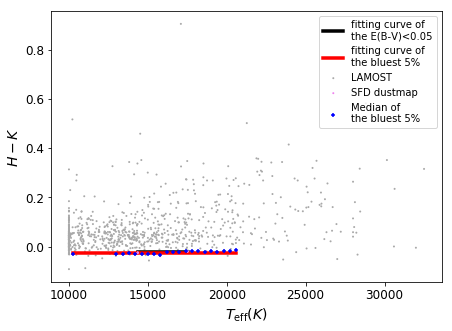

In [29]:
#PLT
plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
#plt.ylim(-1,2)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='darkgray',s=4, edgecolors='None',label='LAMOST')

# data we use in the SFD dustmap
plt.scatter(SFD_catalog_teff,SFD_catalog_color,alpha=1,edgecolors='None',c='violet',s=4,label='SFD dustmap',zorder=2)

# SFD fitcurve
plt.plot(SFD_catalog_teff, SFD_vals, c='black',linewidth = 3.5,label='fitting curve of \nthe E(B-V)<0.05',zorder=1)

# ic plot from blue edge
plt.plot(int_teff, colorvals, c='r',linewidth = 3.5,label='fitting curve of \nthe bluest 5%',zorder=1,alpha=1)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=11,label='Median of\nthe bluest 5%',zorder=2)

# ic from Allen's work 
# plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lime',s=11,label='Allen',zorder=2)

# ic from parsec
#plt.scatter(parsec_teff,parsec_color,c='gold',s=5,label='PARSEC',zorder=2)

### Draw the plot

# plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel(ylabel)
#plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lightgreen',s=15,label='Allen')

plt.legend(loc='upper right')
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)

# plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
#         np.max(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]))
#plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
#       4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig(savename1,dpi=200)
plt.savefig(savename5,dpi=200)
plt.show()

In [10]:
color= [-0.023999999999997357, -0.018999999999998352, -0.019999999999999574, -0.035000000000000142, -0.035000000000000142, -0.031500000000002082, -0.029499999999999638, -0.026000000000000689, -0.035000000000000142, -0.019500000000000739, -0.01899999999999924, -0.032499999999998863, -0.024000000000000909, -0.022999999999999687, -0.023999999999999133, -0.020999999999999908, -0.022999999999999687, -0.026999999999999247, -0.024499999999999744, -0.020999999999999908, -0.026000000000000689, -0.028000000000000469, -0.028499999999999304, -0.028000000000000469, -0.028000000000000469, -0.017999999999998906, -0.017999999999998906, -0.011000000000000121, -0.0090000000000003411, -0.014499999999999069, -0.019999999999999574, -0.01899999999999924, -0.010500000000000398, -0.024999999999999467, -0.022000000000000242, -0.0069999999999996732, -0.0059999999999993392, -0.0059999999999993392, 0.012000000000000455, 0.022000000000000242, 0.022999999999998799, 0.022000000000000242, -0.0040000000000004476, 0.021499999999998742, 0.019000000000000128]
teff = [1.0249999999999999, 1.0649999999999999, 1.105, 1.145, 1.1850000000000001, 1.2250000000000001, 1.2649999999999999, 1.3049999999999999, 1.345, 1.385, 1.425, 1.4650000000000001, 1.5049999999999999, 1.6200000000000001, 1.6599999999999999, 1.7, 1.74, 1.78, 1.8200000000000001, 1.8600000000000001, 1.8999999999999999, 1.9399999999999999, 1.98, 2.02, 2.0600000000000001, 2.1000000000000001, 2.1400000000000001, 2.1800000000000002, 2.2200000000000002, 2.2599999999999998, 2.2999999999999998, 2.3399999999999999, 2.3799999999999999, 2.4199999999999999, 2.46, 2.5, 2.54, 2.5800000000000001, 2.6200000000000001, 2.6600000000000001, 2.7000000000000002, 2.7400000000000002, 2.7799999999999998, 2.8199999999999998, 2.8599999999999999]



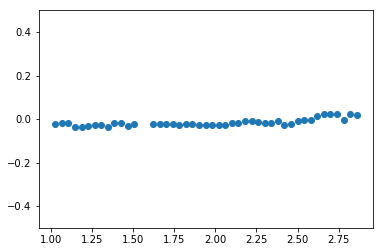

In [11]:
plt.figure()
plt.scatter(teff,color)
plt.ylim(-0.5,0.5)
plt.show()

In [8]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


popt, pcov = curve_fit(func, teff, color)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.